In [1]:
import pandas as pd
import numpy as np
import json
import joblib
import os

In [2]:
with open("../../robustness/robustness_iterations.json") as f:
    iterations = json.load(f)

In [3]:
def load_dataset(function):
    phrogs = pd.read_pickle("/project/rrg-eroussea/projects/protein-function-prediction/out/phrogs/all_phrogs.pkl")
    data = pd.read_pickle(f"/project/rrg-eroussea/projects/protein-function-prediction/data/{function}.pkl")
    data = pd.merge(data, phrogs.loc[:, "#phrog"], how="left", left_index=True, right_index=True)

    return data

def subset_dataset(data, holdout_phrogs):
    holdout = data.loc[data["#phrog"].isin(holdout_phrogs)]
    train = data.loc[~(data["#phrog"].isin(holdout_phrogs))]
    return holdout, train

In [4]:
def load_dataset(function, iteration):
    holdout = pd.read_pickle(f"/project/rrg-eroussea/projects/protein-function-prediction/robustness/out_wNeg/{function}_holdout_{iteration}.pkl")
    negTest = pd.read_pickle(f"/project/rrg-eroussea/projects/protein-function-prediction/robustness/out_wNeg/{function}_negtest_{iteration}.pkl")

    holdout = holdout.drop(columns=["pc", "Accession", "VC", "Host", "host_type", "Annotation", "Category", "#phrog"])
    negTest = negTest.drop(columns=["pc", "Accession", "VC", "Host", "host_type", "Annotation", "Category", "#phrog"])
    
    return pd.concat([holdout, negTest])

#load_dataset("lysis", "1")

In [39]:
functions=["lysis", "cell_wall_depolymerase", "DNA-associated", "pvp", "transcriptional_regulator", "transferase"]

from sklearn.metrics import precision_score, recall_score, f1_score
def eval_robustness(functions, th):
    wd = "/project/rrg-eroussea/projects/protein-function-prediction/robustness/out_wNeg/"
    precisions={}
    recalls={}
    f1s={}
    for function in functions:
        print(function)
        iter_precisions = []
        iter_recalls = []
        iter_f1s = []
        for iteration in range(1, 11):
            clf = joblib.load(os.path.join(wd, f"models/{function}_{iteration}.pkl"))
            test = load_dataset(function, iteration)
            preds = (clf.predict_proba(test.loc[:, 0:1023])[:,1] > th).astype(int)
            recall = recall_score(test.label, preds)
            prec = precision_score(test.label, preds, zero_division=np.nan)
            f1 = f1_score(test.label, preds)
            
            iter_precisions += [prec]
            iter_recalls += [recall]
            iter_f1s += [f1]
        precisions[function] = iter_precisions
        recalls[function] = iter_recalls
        f1s[function] = iter_f1s
    return precisions, recalls, f1s

In [11]:
precisions, recalls, f1s = eval_robustness(functions, 0.5)

lysis
cell_wall_depolymerase
DNA-associated
pvp
transcriptional_regulator
transferase


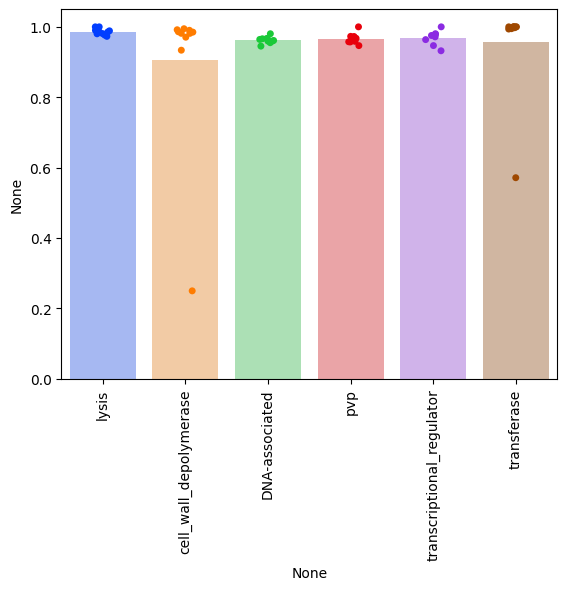

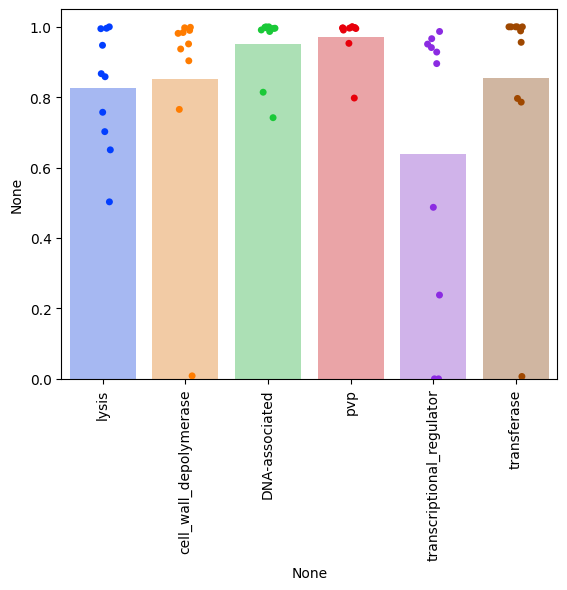

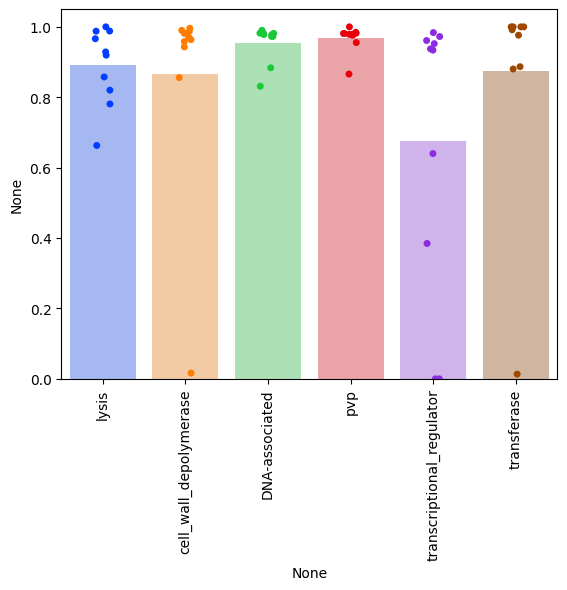

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.stripplot(precisions, palette='bright')
avgs=pd.DataFrame(precisions).mean()
sns.barplot(x=avgs.index, y=avgs, hue=avgs.index, alpha=0.4, palette='bright')
plt.xticks(rotation=90)
#plt.savefig("fig_robustness_precisions.pdf")
plt.show()

sns.stripplot(recalls, palette='bright')
avgs=pd.DataFrame(recalls).mean()
sns.barplot(x=avgs.index, y=avgs, hue=avgs.index, alpha=0.4, palette='bright')
plt.xticks(rotation=90)
#plt.savefig("fig_robustness_recalls.pdf")
plt.show()

sns.stripplot(f1s, palette='bright')
avgs=pd.DataFrame(f1s).mean()
sns.barplot(x=avgs.index, y=avgs, hue=avgs.index, alpha=0.4, palette='bright')
plt.xticks(rotation=90)
#plt.savefig("fig_robustness_f1s.pdf")
plt.show()

In [11]:
display(pd.DataFrame(precisions).mean())
display(pd.DataFrame(precisions))

display(pd.DataFrame(recalls).mean())
display(pd.DataFrame(recalls))

display(pd.DataFrame(f1s).mean())
pd.DataFrame(f1s)

lysis                        0.986054
cell_wall_depolymerase       0.906505
DNA-associated               0.962421
pvp                          0.965922
transcriptional_regulator    0.968602
transferase                  0.955749
dtype: float64

,lysis,cell_wall_depolymerase,DNA-associated,pvp,transcriptional_regulator,transferase
0,0.976623,0.933673,0.966102,0.967442,1.000000,1.000000
1,0.980237,0.981579,0.945205,0.957143,NaN,1.000000
2,0.972993,0.991758,0.965977,1.000000,0.975483,0.994822
3,0.985660,0.990208,0.959471,0.946667,0.946767,1.000000
4,0.988685,0.250000,0.961285,0.957614,0.963771,0.993789
5,1.000000,0.994695,0.959402,0.958904,0.980456,1.000000
6,1.000000,0.985000,0.964286,0.961464,NaN,0.997455
7,0.990091,0.986068,0.980392,0.972561,0.978723,1.000000
8,0.985348,0.981481,0.967144,0.972973,0.971581,0.571429
9,0.980903,0.970588,0.954949,0.964450,0.932039,1.000000


lysis                        0.827656
cell_wall_depolymerase       0.851728
DNA-associated               0.952180
pvp                          0.972497
transcriptional_regulator    0.639482
transferase                  0.853403
dtype: float64

,lysis,cell_wall_depolymerase,DNA-associated,pvp,transcriptional_regulator,transferase
0,0.650519,0.983871,0.814286,0.995215,0.238095,0.796610
1,0.995984,0.998661,0.741935,0.996283,0.000000,1.000000
2,0.502829,0.937054,0.998621,1.000000,0.895594,0.988424
3,0.947610,0.951442,0.997311,0.797753,0.928396,1.000000
4,0.757313,0.008475,0.995589,0.953125,0.941176,1.000000
5,1.000000,0.997340,0.986813,1.000000,0.986885,1.000000
6,0.866972,0.989950,1.000000,0.996671,0.000000,0.956098
7,0.858268,0.903546,1.000000,0.996875,0.966387,0.786164
8,0.702350,0.981481,0.996095,0.990826,0.950974,0.006734
9,0.994718,0.765464,0.991144,0.998220,0.487310,1.000000


lysis                        0.891200
cell_wall_depolymerase       0.866250
DNA-associated               0.955218
pvp                          0.968387
transcriptional_regulator    0.676562
transferase                  0.874522
dtype: float64

,lysis,cell_wall_depolymerase,DNA-associated,pvp,transcriptional_regulator,transferase
0,0.780893,0.958115,0.883721,0.981132,0.384615,0.886792
1,0.988048,0.990046,0.831325,0.976321,0.000000,1.000000
2,0.663019,0.963630,0.982028,1.000000,0.933833,0.991613
3,0.966261,0.970438,0.978025,0.865854,0.937491,1.000000
4,0.857669,0.016393,0.978137,0.955364,0.952340,0.996885
5,1.000000,0.996016,0.972914,0.979021,0.983660,1.000000
6,0.928747,0.987469,0.981818,0.978751,0.000000,0.976339
7,0.919479,0.943005,0.990099,0.984568,0.972516,0.880282
8,0.820122,0.981481,0.981406,0.981818,0.961167,0.013311
9,0.987762,0.855908,0.972710,0.981044,0.640000,1.000000


In [12]:
pd.DataFrame(precisions).mean().mean()

0.9575423539723081

#### Using a more stringent confidence threshold of 95%

In [4]:
precisions, recalls, f1s = eval_robustness(functions, 0.95)
pd.DataFrame(precisions).mean()

lysis                        0.991076
cell_wall_depolymerase       0.933839
DNA-associated               0.987286
pvp                          0.989373
transcriptional_regulator    0.978497
transferase                  0.998843
dtype: float64

In [15]:
pd.DataFrame(precisions).mean().mean()

0.979819